<a href="https://colab.research.google.com/github/freakdeco/RollShift/blob/main/AnalogAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**General Info**

---


###--LAB:
-> (L) Light

-> (A) Red & Green

->(B) Yellow & Blue

---

###--HSL:
-> (H) Hue

-> (S) Saturation

->(L) Luminosity

---

###--BRG:
-> (B) Blue

-> (R) Red

->(G) Green

---


**Features to add**

-- Adding Metadata (Film Stock, Development Date, Shooting Data etc)

-- Batch upoload and Batch Download


In [195]:
#!pip3 install opencv-python

In [196]:
import pandas as pd
import numpy as np
import cv2
import argparse
from google.colab.patches import cv2_imshow
from PIL import Image as PILImage
import matplotlib.pyplot as plt

#from exif import Image as ExifImage


In [197]:
#!pip3 install EXIF

In [198]:
image_path = '/content/drive/MyDrive/DATA/Negatives/ezgif-2-875ecc9e07.jpg' #input('Please enter the path to the image: ')
rawscan = cv2.imread(image_path)

## Main Functions

In [199]:
#find the base color for color correction
def find_base(neg):
    max_sum = 0
    white_sample = [0, 0]
    for y in range(neg.shape[0]):
        for x in range(neg.shape[1]):
            local_sum = np.sum(neg[y, x])
            if local_sum > max_sum:
                max_sum = local_sum
                white_sample = [y, x]
    return [neg[white_sample[0], white_sample[1], chan] for chan in range(neg.shape[2])]


In [200]:
def invert(neg, base):
    b, g, r = cv2.split(neg)
    b = np.clip((b / base[0]) * 255, 0, 255)
    g = np.clip((g / base[1]) * 255, 0, 255)
    r = np.clip((r / base[2]) * 255, 0, 255 )
    res = cv2.merge((b.astype(np.uint8), g.astype(np.uint8), r.astype(np.uint8)))
    res = 255 - res
    return res

In [201]:
#Display the naturalized image
#v2_imshow(naturalized_image)

In [202]:
#gamma correction
def adjust_gamma(image, gamma=1.0):
    # Create a lookup table for all pixel values [0, 255]
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # Apply gamma correction using the lookup table
    return cv2.LUT(naturalized_image, table)

In [203]:
# white balance
def apply_white_balance(image):
    # Convert to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    # Split the LAB image into L, A, B channels
    L, A, B = cv2.split(lab_image)

    # Calculate the mean of A and B channels
    mean_A = np.mean(A)
    mean_B = np.mean(B)

    # Calculate the adjustments  to neutralize the image
    A_correction = A - (mean_A - 128)
    B_correction = B - (mean_B - 128)

    # Clip values to stay within the alid range
    A_correction = np.clip(A_correction, 0, 255).astype(np.uint8)
    B_correction = np.clip(B_correction, 0, 255).astype(np.uint8)

    # Merge the channels back with corrected A and B
    corrected_lab_image = cv2.merge((L, A_correction, B_correction))

    # Convert image to BGR color space
    white_balanced_image = cv2.cvtColor(corrected_lab_image, cv2.COLOR_Lab2BGR)

    return white_balanced_image



In [204]:
def adjust_saturation(image, saturation_factor=1):
    """

    Args:
      image:
      saturation_factor:

    Returns:

    """
    # HSV color
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_factor, 0, 255)

    saturated_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return saturated_image




In [205]:
#cv2.imwrite('meta_angle.jpg', image1)

## Code

Image loaded successfully from /content/drive/MyDrive/DATA/Negatives/ezgif-2-875ecc9e07.jpg


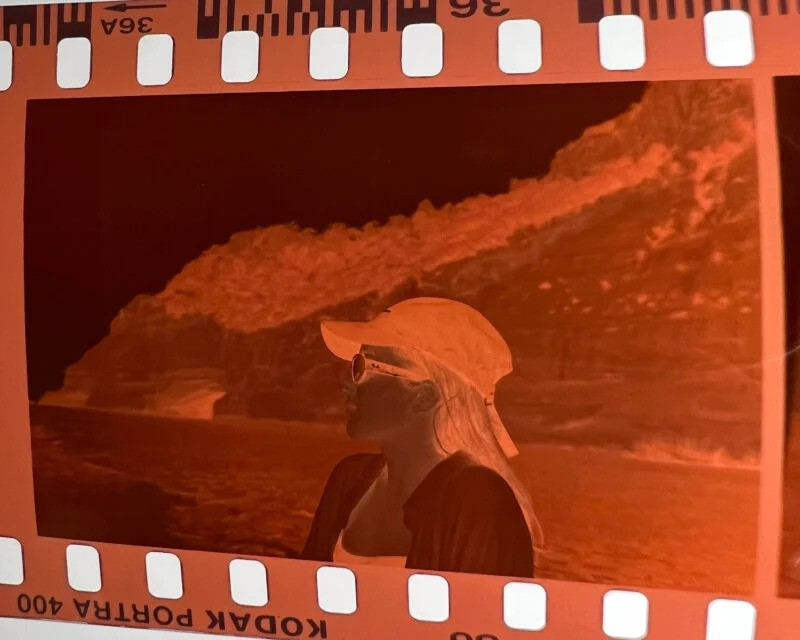

In [206]:
if rawscan is None:
    print(f"Error: Unable to load image from {image_path}")
else:
    print(f"Image loaded successfully from {image_path}")
    cv2_imshow(rawscan)

In [207]:
base_color = find_base(rawscan)
inverted_image = invert(rawscan, base_color)

Displaying the inverted image:


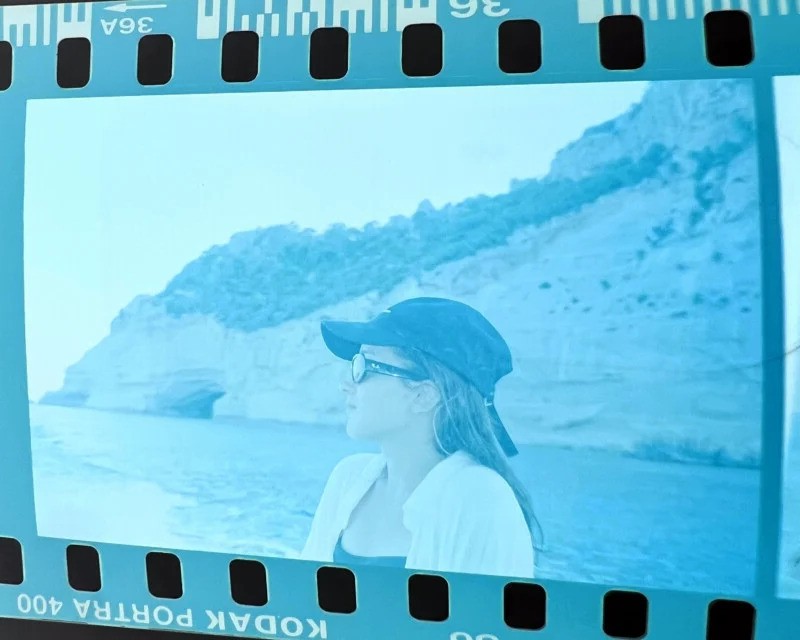

In [208]:
print("Displaying the inverted image:")
cv2_imshow(inverted_image)

In [209]:

lab_image = cv2.cvtColor(inverted_image, cv2.COLOR_BGR2Lab)  # Convert to LAB color space
L, A, B = cv2.split(lab_image)  # Split into channels

In [210]:

L = cv2.add(L, 15)      #  Brightness
A = cv2.add(A, 20)     #  Red
B = cv2.add(B, 20)     # Yellow


In [211]:
# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
L = clahe.apply(L)

In [212]:
# Merge the channels
modified_lab_image = cv2.merge((L, A, B))

In [213]:
# Convert back to BGR
naturalized_image = cv2.cvtColor(modified_lab_image, cv2.COLOR_Lab2BGR)

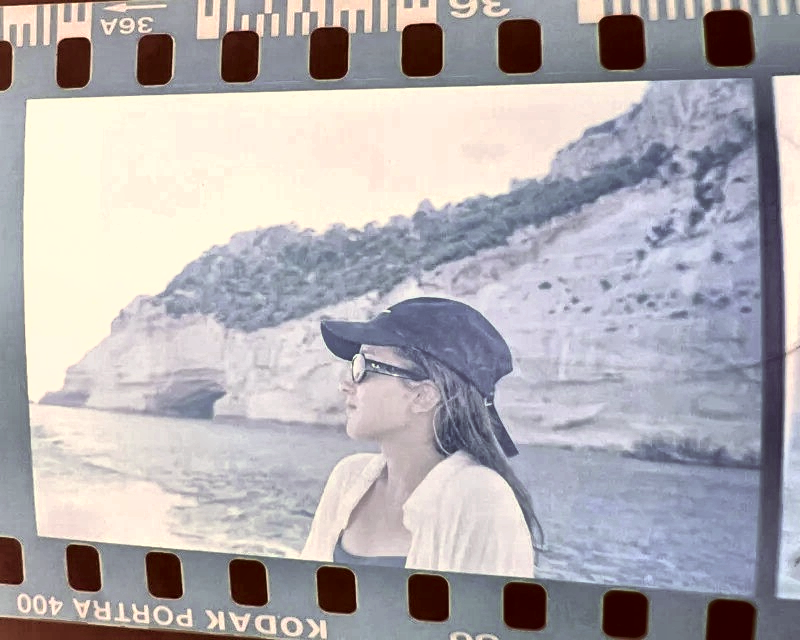

In [214]:
gamma_value = 0.9  # Adjust this value to control the gamma curve (1.0 means = change)
gamma_corrected_image = adjust_gamma(naturalized_image, gamma=gamma_value)
cv2_imshow(gamma_corrected_image)


In [215]:
#image = gamma_corrected_image
white_balanced_image = apply_white_balance(image)


In [216]:
saturation_factor = 1.5  # (1.0 = original, >1.0 = more saturation)
#saturated_image = adjust_saturation(image, saturation_factor)
#dcv2_imshow(saturated_image)


In [217]:
print(base_color[0])

B, G, R = cv2.split(saturated_image)
B = np.clip((B / base_color[0]) * 255, 0, 255)
G = np.clip((G / base_color[1]) * 255, 0, 255)
R = np.clip((R / base_color[2]) * 255, 0, 255 )


image1 = cv2.merge((B.astype(np.uint8), G.astype(np.uint8), R.astype(np.uint8)))
#cv2_imshow(image1)


255


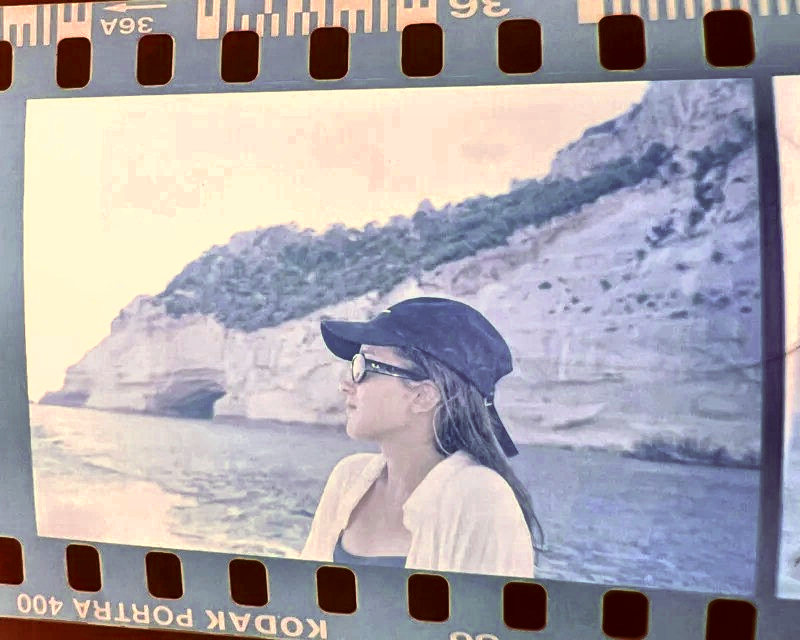

In [218]:
cv2_imshow(image1)